In [1]:
from environnement import Eight_american_env
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.core.rl_module.rl_module import RLModuleSpec
from ray.rllib.core.rl_module.multi_rl_module import MultiRLModuleSpec
from rl_module import VPGTorchRLModule
import matplotlib.pyplot as plt
from ray.rllib.core.rl_module.rl_module import RLModule
from gymnasium.spaces.utils import flatten
from ray.rllib.utils.torch_utils import flatten_inputs_to_1d_tensor
import numpy as np
import torch

In [2]:
env = Eight_american_env(config={"nb_agents": 2})

In [3]:
config = (
    PPOConfig()
    # FrozenLake has a discrete observation space (ints).
    .environment(Eight_american_env,
                 env_config={"nb_agents": 2})
    .env_runners(
        num_env_runners=3,
        num_envs_per_env_runner=2,
        batch_mode="complete_episodes",
    )
    .multi_agent(
        policies={"p1", "p2"},
        policy_mapping_fn=lambda agent_id, episode, **kw: f"p{agent_id[-1]}",
        

    )
    .rl_module(
        rl_module_spec=MultiRLModuleSpec(
            rl_module_specs={
                "p1": RLModuleSpec(
                    module_class=VPGTorchRLModule,
                    model_config={"hidden_dim_actor": 64,
                                  "hidden_dim_critic": 32,
                                  "agent_name": "player_1"},
                    observation_space=env.observation_spaces["player_1"],
                    action_space=env.action_spaces["player_1"]
                ),
                "p2": RLModuleSpec(
                    module_class=VPGTorchRLModule,
                    model_config={"hidden_dim_actor": 32,
                                  "hidden_dim_critic": 16,
                                  "agent_name": "player_2"},
                    observation_space=env.observation_spaces["player_2"],
                    action_space=env.action_spaces["player_2"]
                ),
            }
        )
    )
    .training(use_critic=True,
              use_gae=True,
              lr=0.03,
              train_batch_size_per_learner=20000,
              minibatch_size=3080,
              num_epochs=4
              )  # Enable critic and GAE
    .evaluation(evaluation_interval=1,
                evaluation_duration_unit="episodes",
                evaluation_duration=5)
)

In [ ]:
ppo = config.build_algo()

2025-04-20 21:31:46,667	WARNING algorithm_config.py:4704 -- You are running PPO on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html
2025-04-20 21:31:53,695	INFO worker.py:1852 -- Started a local Ray instance.
(MultiAgentEnvRunner pid=38392) 2025-04-20 21:32:01,318	ERROR multi_agent_env_runner.py:814 -- Your environment (<Eight_american_env<rllib-multi-agent-env-v0>>) does not abide to the new gymnasium-style API!
(MultiAgentEnvRunner pid=38392) From Ray 2.3 on, RLlib only supports the new (gym>=0.26 or gymnasium) Env APIs.
(MultiAgentEnvRunner pid=38392) In particular, the `step()` method seems to be faulty.
(MultiAgentEnvRunner pid=38392) Learn more about the most important changes here:
(MultiAgentEnvRunner 

(MultiAgentEnvRunner pid=31384) The winner is:  1
(MultiAgentEnvRunner pid=38392) The winner is:  2 [repeated 13x across cluster]
(MultiAgentEnvRunner pid=38392) The winner is:  1 [repeated 10x across cluster]
(MultiAgentEnvRunner pid=31384) The winner is:  1 [repeated 12x across cluster]
(MultiAgentEnvRunner pid=17352) The winner is:  1
(MultiAgentEnvRunner pid=17352) The winner is:  2
(MultiAgentEnvRunner pid=38392) The winner is:  2 [repeated 11x across cluster]
(MultiAgentEnvRunner pid=31384) The winner is:  2 [repeated 13x across cluster]
(MultiAgentEnvRunner pid=31384) The winner is:  1 [repeated 11x across cluster]
(MultiAgentEnvRunner pid=17352) The winner is:  1 [repeated 8x across cluster]
(MultiAgentEnvRunner pid=38392) The winner is:  1 [repeated 3x across cluster]
(MultiAgentEnvRunner pid=17352) The winner is:  1 [repeated 5x across cluster]
(MultiAgentEnvRunner pid=31384) The winner is:  1 [repeated 3x across cluster]
(MultiAgentEnvRunner pid=17352) The winner is:  1 [rep

In [5]:
# Initialize lists to store rewards for each agent
test_rewards_p1 = []
test_rewards_p2 = []
episodes = []

# Training loop
for i in range(100):  # Train for 100 iterations
    train_results = ppo.train()
    
    # Extract rewards for each agent
    test_rewards_p1.append(train_results["env_runners"]["agent_episode_returns_mean"]["player_1"])
    test_rewards_p2.append(train_results["env_runners"]["agent_episode_returns_mean"]["player_2"])
    print("--------------------------------")
    print(f"Iteration {i + 1}:")
    print("--------------------------------")
    episodes.append(i + 1)

The winner is:  1
The winner is:  2
The winner is:  1
The winner is:  2
The winner is:  2
--------------------------------
Iteration 1:
--------------------------------
The winner is:  2
The winner is:  1
The winner is:  2
The winner is:  2
The winner is:  1
--------------------------------
Iteration 2:
--------------------------------
The winner is:  2
The winner is:  1
The winner is:  2
The winner is:  1
The winner is:  1
--------------------------------
Iteration 3:
--------------------------------
The winner is:  2
The winner is:  1
The winner is:  2
The winner is:  1
The winner is:  1
--------------------------------
Iteration 4:
--------------------------------
The winner is:  1
The winner is:  2
The winner is:  1
The winner is:  1
The winner is:  1
--------------------------------
Iteration 5:
--------------------------------
The winner is:  1
The winner is:  1
The winner is:  1
The winner is:  1
The winner is:  1
--------------------------------
Iteration 6:
-------------------

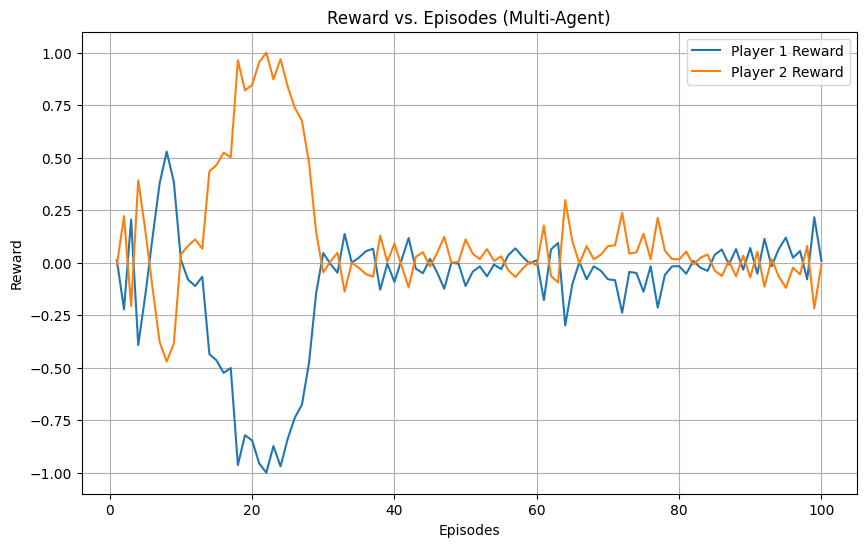

In [7]:
# Plot rewards for both agents
plt.figure(figsize=(10, 6))
plt.plot(episodes, test_rewards_p1, label="Player 1 Reward")
plt.plot(episodes, test_rewards_p2, label="Player 2 Reward")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Reward vs. Episodes (Multi-Agent)")
plt.legend()
plt.grid()
plt.show()

In [8]:
ppo.save_to_path("c:/Users/kouas/Documents/RL_revisions/8_aremicains/weights/")

'c:\\Users\\kouas\\Documents\\RL_revisions\\8_aremicains\\weights'